In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models

In [2]:
x_range = np.linspace(-8*np.pi,8*np.pi,1000)
normal_frequencies = np.linspace(-2,2,1000)
weird_frequencies = np.hstack((np.linspace(-10,-5,500),np.linspace(5,10,500)))
normal_amplitudes = np.linspace(-2,2,1000)
weird_amplitudes =np.hstack((np.linspace(-5,-2,500),np.linspace(2,5,500)))
print(normal_frequencies.shape)
print(weird_frequencies.shape)
print(normal_amplitudes.shape)
print(weird_amplitudes.shape)

(1000,)
(1000,)
(1000,)
(1000,)


In [13]:
def build_normal_signals(num=1000,num_components=3):
  signals = []
  for _ in range(num):
    freqs, amps = np.random.choice(normal_frequencies,num_components), np.random.choice(normal_amplitudes,num_components)
    sigs = [amps[i]*np.sin(freqs[i]*x_range) for i in range(len(freqs))]
    signals.append(np.sum(sigs, axis=0))
  return np.array(signals)



def build_weird_signals(num=1000,num_components=3):
  signals = []
  for _ in range(num):
    freqs, amps = np.random.choice(normal_frequencies,num_components), np.random.choice(normal_amplitudes,num_components)

    sigs = [amps[i]*np.sin(freqs[i]*x_range) for i in range(len(freqs))]
    signal = np.sum(sigs, axis=0)
    signal = signal + np.random.choice(weird_amplitudes)*np.sin(np.random.choice(weird_frequencies)*x_range)
    signals.append(signal)
  return np.array(signals)

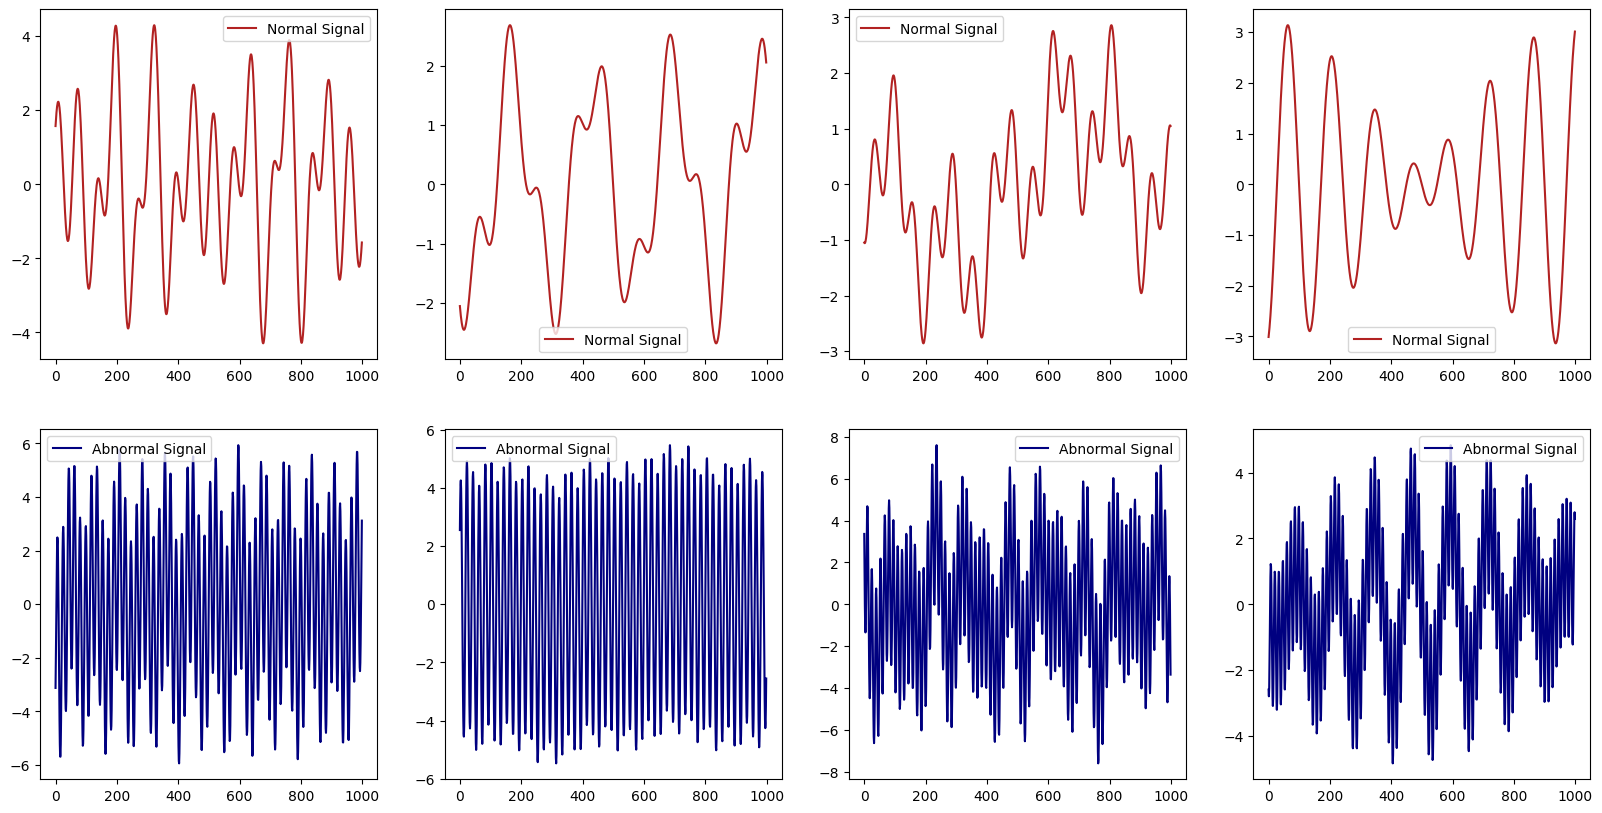

In [14]:
normal_signals = build_normal_signals()
weird_signals = build_weird_signals()
plt.figure(figsize=(20,10))
for i in range(1,9):
  plt.subplot(2,4,i)
  if i>4:
    plt.plot(weird_signals[np.random.choice(500)],color='navy',label='Abnormal Signal')
    plt.legend()
  if i<=4:
    plt.plot(normal_signals[np.random.choice(500)],color='firebrick',label='Normal Signal')
    plt.legend()

In [15]:
def build_cnn_encoder_decoder(input_shape):
    model = models.Sequential()

    model.add(layers.Input(shape=input_shape))
    # Encoder
    model.add(layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=2, padding='same'))
    model.add(layers.Conv1D(filters=16, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=2, padding='same'))

    # Decoder
    model.add(layers.Conv1D(filters=16, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.UpSampling1D(size=2))
    model.add(layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.UpSampling1D(size=2))
    model.add(layers.Conv1D(filters=1, kernel_size=3, padding='same', activation='linear'))

    model.compile(optimizer='adam', loss='mse')
    return model

In [16]:
normal_signals = normal_signals.reshape(normal_signals.shape[0], normal_signals.shape[1], 1)
weird_signals = weird_signals.reshape(weird_signals.shape[0], weird_signals.shape[1], 1)
input_shape = (normal_signals.shape[1], 1)  # (1000, 1)

print(normal_signals.shape)
print(weird_signals.shape)
print(input_shape)

(1000, 1000, 1)
(1000, 1000, 1)
(1000, 1)


In [17]:
model = build_cnn_encoder_decoder(input_shape)

# Train the model
model.fit(normal_signals, normal_signals, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 1.5068 - val_loss: 0.1344
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0745 - val_loss: 0.0198
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0156 - val_loss: 0.0085
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0081 - val_loss: 0.0061
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0063 - val_loss: 0.0052
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0055 - val_loss: 0.0046
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0046 - val_loss: 0.0039
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0040 - val_loss: 0.0032
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0

In [18]:
# Get reconstruction error for normal signals
normal_signals = normal_signals.reshape(normal_signals.shape[0], normal_signals.shape[1], 1)

reconstructed_normal = model.predict(normal_signals)

mse_normal = np.mean(np.power(normal_signals - reconstructed_normal, 2), axis=1)

# Get reconstruction error for weird signals
reconstructed_weird = model.predict(weird_signals)

mse_weird = np.mean(np.power(weird_signals - reconstructed_weird, 2), axis=1)

# Define a threshold to distinguish between normal and anomalous signals
threshold = np.percentile(mse_normal, 99)

# Detect anomalies
normal_signals = build_normal_signals()
normal_signals = normal_signals.reshape(normal_signals.shape[0], normal_signals.shape[1], 1)
reconstructed_normal = model.predict(normal_signals)
mse_normal = np.mean(np.power(normal_signals - reconstructed_normal, 2), axis=1)
true_anomalies = mse_weird > threshold
false_anomalies = mse_normal > threshold
false_normal = mse_weird < threshold
true_normal = mse_normal > threshold

true_anomalies_count = np.sum(mse_weird > threshold)
false_anomalies_count = np.sum(mse_normal > threshold)
false_normal_count = np.sum(mse_weird < threshold)
true_normal_count = np.sum(mse_normal < threshold)

print(f'Anomalies classified as Anomalies: {true_anomalies_count}')
print(f'Normal classified as Anomalies: {false_anomalies_count}')
print(f'Anomalies classified as Normal: {false_normal_count}')
print(f'Normal classified as Normal: {true_normal_count}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
(1000, 1000, 1)
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
(1000, 1000, 1)
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Anomalies classified as Anomalies: 1000
Normal classified as Anomalies: 2
Anomalies classified as Normal: 0
Normal classified as Normal: 998


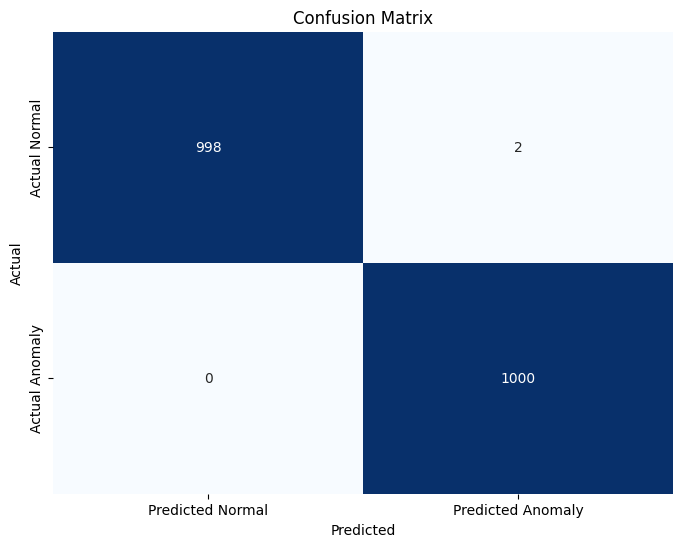

In [19]:
conf_matrix = np.array([[true_normal_count, false_anomalies_count],
                        [false_normal_count, true_anomalies_count]])

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted Normal', 'Predicted Anomaly'],
            yticklabels=['Actual Normal', 'Actual Anomaly'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [20]:
setup_dict = {
    'low_normal_freq': -2,
    'high_normal_freq': 2,
    'low_anomaly_freq': -10,
    'high_anomaly_freq': 10,
    'low_normal_amplitude': -2,
    'high_normal_amplitude': 2,
    'low_anomaly_amplitude': -5,
    'high_anomaly_amplitude': 5
}

In [21]:
def full_process(setup_dict=setup_dict):
    # Generate the normal frequencies and amplitudes based on the setup_dict
  normal_frequencies = np.linspace(setup_dict['low_normal_freq'], setup_dict['high_normal_freq'], 1000)
  weird_frequencies = np.hstack((np.linspace(setup_dict['low_anomaly_freq'], setup_dict['low_normal_freq'], 500),np.linspace(setup_dict['high_normal_freq'], setup_dict['high_anomaly_freq'], 500)))
  normal_amplitudes = np.linspace(setup_dict['low_normal_amplitude'], setup_dict['high_normal_amplitude'], 1000)
  weird_amplitudes = np.hstack((np.linspace(setup_dict['low_anomaly_amplitude'], setup_dict['low_normal_amplitude'], 500),np.linspace(setup_dict['high_normal_amplitude'], setup_dict['high_anomaly_amplitude'], 500)))



  def build_normal_signals(num=1000,num_components=3):
    signals = []
    for _ in range(num):
      freqs, amps = np.random.choice(normal_frequencies,num_components), np.random.choice(normal_amplitudes,num_components)
      sigs = [amps[i]*np.sin(freqs[i]*x_range) for i in range(len(freqs))]
      signals.append(np.sum(sigs, axis=0))
    return np.array(signals)



  def build_weird_signals(num=1000,num_components=3):
    signals = []
    for _ in range(num):
      freqs, amps = np.random.choice(normal_frequencies,num_components), np.random.choice(normal_amplitudes,num_components)

      sigs = [amps[i]*np.sin(freqs[i]*x_range) for i in range(len(freqs))]
      signal = np.sum(sigs, axis=0)
      signal = signal + np.random.choice(weird_amplitudes)*np.sin(np.random.choice(weird_frequencies)*x_range)
      signals.append(signal)
    return np.array(signals)

  normal_signals = build_normal_signals()
  weird_signals = build_weird_signals()
  normal_signals = normal_signals.reshape(normal_signals.shape[0], normal_signals.shape[1], 1)
  weird_signals = weird_signals.reshape(weird_signals.shape[0], weird_signals.shape[1], 1)
  input_shape = (normal_signals.shape[1], 1)  # (1000, 1)
  model = build_cnn_encoder_decoder(input_shape)

# Train the model
  model.fit(normal_signals, normal_signals, epochs=50, batch_size=32, validation_split=0.1)
  reconstructed_normal = model.predict(normal_signals)
  mse_normal = np.mean(np.power(normal_signals - reconstructed_normal, 2), axis=1)

  # Get reconstruction error for weird signals
  reconstructed_weird = model.predict(weird_signals)
  mse_weird = np.mean(np.power(weird_signals - reconstructed_weird, 2), axis=1)

  # Define a threshold to distinguish between normal and anomalous signals
  threshold = np.percentile(mse_normal, 99)
  normal_signals = build_normal_signals()
  normal_signals = normal_signals.reshape(normal_signals.shape[0], normal_signals.shape[1], 1)
  reconstructed_normal = model.predict(normal_signals)
  mse_normal = np.mean(np.power(normal_signals - reconstructed_normal, 2), axis=1)
  # Detect anomalies
  true_anomalies = mse_weird > threshold
  false_anomalies = mse_normal > threshold
  false_normal = mse_weird < threshold
  true_normal = mse_normal > threshold

  true_anomalies_count = np.sum(mse_weird > threshold)
  false_anomalies_count = np.sum(mse_normal > threshold)
  false_normal_count = np.sum(mse_weird < threshold)
  true_normal_count = np.sum(mse_normal < threshold)

  print(f'Anomalies classified as Anomalies: {true_anomalies_count}')
  print(f'Normal classified as Anomalies: {false_anomalies_count}')
  print(f'Anomalies classified as Normal: {false_normal_count}')
  print(f'Normal classified as Normal: {true_normal_count}')
  conf_matrix = np.array([[true_normal_count, false_anomalies_count],
                        [false_normal_count, true_anomalies_count]])

# Plotting the confusion matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
              xticklabels=['Predicted Normal', 'Predicted Anomaly'],
              yticklabels=['Actual Normal', 'Actual Anomaly'])
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 1.6912 - val_loss: 0.1910
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.1065 - val_loss: 0.0257
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0231 - val_loss: 0.0118
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0116 - val_loss: 0.0071
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0076 - val_loss: 0.0050
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0055 - val_loss: 0.0040
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0046 - val_loss: 0.0035
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0039 - val_loss: 0.0030
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0036 - val_loss: 0.0026
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0

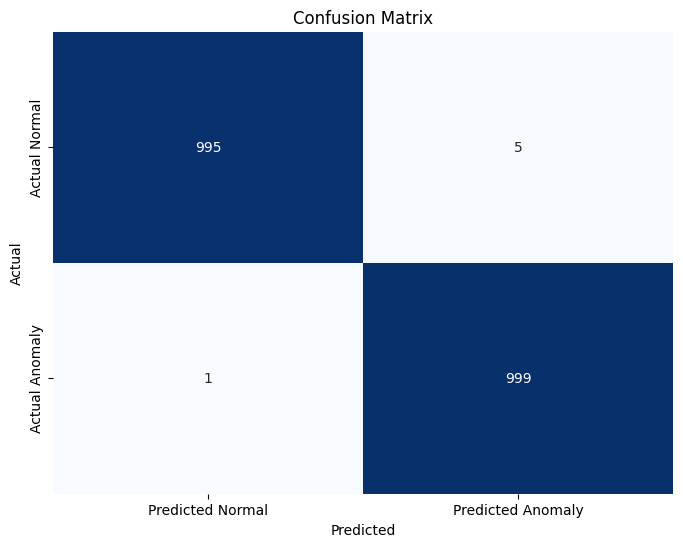

In [22]:
full_process(setup_dict)